In [ ]:
from lle import LLE, WorldState, Action, World
from lle.exceptions import InvalidWorldStateError
import marlenv
import marl
import matplotlib.pyplot as plt
from marl.other.local_graph import LocalGraphTrainer, LocalGraphBottleneckFinder
import numpy as np
import networkx as nx

def state2array(state: WorldState, world: World) -> np.ndarray:
    array = state.as_array()
    array[0] = array[0] / world.height
    array[1] = array[1] / world.width
    return array


def state_hash(state: WorldState, world: World):
    arr_state = state2array(state, world)
    return hash(arr_state.data.tobytes())


In [2]:
env = LLE.from_file("maps/subgraph-1agent.toml").obs_type("layered").single_objective()
world = env.world
# env = LLE.level(6).obs_type("state").single_objective()
masked_actions = np.full((1, 5), True)
masked_actions[0, Action.STAY.value] = False
env = marlenv.Builder(env).mask_actions(masked_actions).build()


qnetwork = marl.nn.model_bank.CNN.from_env(env)
policy = marl.policy.EpsilonGreedy.linear(1.0, 0.05, 100_000)
algo = marl.algo.DQN(qnetwork, policy, marl.policy.ArgMax())
dqn_trainer = marl.training.DQNTrainer(
    qnetwork,
    policy,
    marl.models.TransitionMemory(10_000),
    None,
    gamma=0.95,
    train_interval=(1, "episode"),
)
dqn_trainer = None

In [27]:
from collections import defaultdict

def get_bottlenecks_stats(finder: LocalGraphBottleneckFinder):
    graph = nx.Graph()
    vertex_positions = dict()
    bottleneck_probs = dict[tuple[tuple[int, int],tuple[int, int]], float]()
    hit_count = defaultdict(int)
    apparition_counts = defaultdict(int)

    for i in range(world.height):
        for j in range(world.width):
            from_state = WorldState([(i, j)], [], [True])
            vertex_positions[from_state.agents_positions[0]] = (j, i)
            try:
                world.set_state(from_state)
                for action in world.available_joint_actions():
                    if action == [Action.STAY]:
                        continue
                    world.set_state(from_state)
                    world.step(action)
                    new_state = world.get_state()
                    edge = (state_hash(from_state, world), state_hash(new_state, world))

                    graph.add_edge(from_state.agents_positions[0], new_state.agents_positions[0])
                    hit_count[i, j] += finder.hit_count.get(edge, 0)
                    apparition_counts[i, j] += finder.apparition_count.get(edge, 0)
                    bottleneck_probability = finder.predict(edge)
                    if bottleneck_probability > 0:
                        bottleneck_probs[from_state.agents_positions[0], new_state.agents_positions[0]] = bottleneck_probability
            except InvalidWorldStateError:
                pass
    return graph, vertex_positions, bottleneck_probs

def show_bottlenecks(graph, vertex_positions: dict, bottleneck_probs: dict[tuple, float]):
    plt.figure(figsize=(15, 10))
    nx.draw_networkx_nodes(graph, pos=vertex_positions, label=False, node_size=100)
    nx.draw_networkx_edges(graph, pos=vertex_positions)
    nx.draw_networkx_edge_labels(graph, pos=vertex_positions, edge_labels={k: f"{v:.3f}" for k, v in bottleneck_probs.items()})
    #plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    # plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    plt.axis("off")
    plt.tight_layout()
    plt.savefig("bottlenecks.svg")
    plt.show()




Testing: 100%|██████████| 1/1 [00:00<00:00, 27.44Episode/s]




        0 Average score: 2.0



























































































































































































































Training: 100%|██████████| 1000000/1000000 [00:42<00:00, 23764.88Step/s]


{((4, 11), (4, 12)): [0.0027548209366391185]}
{((4, 11), (4, 12)): [0.0027548209366391185], ((4, 12), (4, 13)): [0.0027548209366391185]}
{((4, 11), (4, 12)): [0.0027548209366391185], ((4, 12), (4, 13)): [0.0027548209366391185], ((4, 13), (5, 13)): [0.0027548209366391185]}
{((4, 11), (4, 12)): [0.0027548209366391185], ((4, 12), (4, 13)): [0.0027548209366391185], ((4, 13), (5, 13)): [0.0027548209366391185], ((5, 9), (5, 10)): [0.013774104683195593]}
{((4, 11), (4, 12)): [0.0027548209366391185], ((4, 12), (4, 13)): [0.0027548209366391185], ((4, 13), (5, 13)): [0.0027548209366391185], ((5, 9), (5, 10)): [0.013774104683195593], ((5, 10), (5, 11)): [1.0]}
{((4, 11), (4, 12)): [0.0027548209366391185], ((4, 12), (4, 13)): [0.0027548209366391185], ((4, 13), (5, 13)): [0.0027548209366391185], ((5, 9), (5, 10)): [0.013774104683195593], ((5, 10), (5, 11)): [1.0], ((5, 11), (4, 11)): [0.0027548209366391185]}





Testing: 100%|██████████| 1/1 [00:00<00:00, 27.73Episode/s]



        0 Average score: 2.0




























































































































































































































Training: 100%|██████████| 1000000/1000000 [00:43<00:00, 23066.42Step/s]


{((4, 11), (4, 12)): [0.0027548209366391185], ((4, 12), (4, 13)): [0.0027548209366391185], ((4, 13), (5, 13)): [0.0027548209366391185], ((5, 9), (5, 10)): [0.013774104683195593], ((5, 10), (5, 11)): [1.0], ((5, 11), (4, 11)): [0.0027548209366391185], ((3, 9), (4, 9)): [0.0026954177897574125]}
{((4, 11), (4, 12)): [0.0027548209366391185], ((4, 12), (4, 13)): [0.0027548209366391185], ((4, 13), (5, 13)): [0.0027548209366391185], ((5, 9), (5, 10)): [0.013774104683195593], ((5, 10), (5, 11)): [1.0], ((5, 11), (4, 11)): [0.0027548209366391185], ((3, 9), (4, 9)): [0.0026954177897574125], ((4, 9), (5, 9)): [0.0026954177897574125]}
{((4, 11), (4, 12)): [0.0027548209366391185], ((4, 12), (4, 13)): [0.0027548209366391185], ((4, 13), (5, 13)): [0.0027548209366391185], ((5, 9), (5, 10)): [0.013774104683195593, 0.03234501347708895], ((5, 10), (5, 11)): [1.0], ((5, 11), (4, 11)): [0.0027548209366391185], ((3, 9), (4, 9)): [0.0026954177897574125], ((4, 9), (5, 9)): [0.0026954177897574125]}
{((4, 11), 




Testing: 100%|██████████| 1/1 [00:00<00:00, 20.34Episode/s]



        0 Average score: 2.0
































































































































































































































Training: 100%|██████████| 1000000/1000000 [00:44<00:00, 22657.05Step/s]


{((4, 11), (4, 12)): [0.0027548209366391185], ((4, 12), (4, 13)): [0.0027548209366391185], ((4, 13), (5, 13)): [0.0027548209366391185], ((5, 9), (5, 10)): [0.013774104683195593, 0.03234501347708895], ((5, 10), (5, 11)): [1.0, 1.0, 1.0], ((5, 11), (4, 11)): [0.0027548209366391185], ((3, 9), (4, 9)): [0.0026954177897574125], ((4, 9), (5, 9)): [0.0026954177897574125]}





Testing: 100%|██████████| 1/1 [00:00<00:00, 15.11Episode/s]



        0 Average score: 2.0
























































































































Training:  13%|█▎        | 125642/1000000 [03:05<21:30, 677.59Step/s]  











































































































Training: 100%|██████████| 1000000/1000000 [00:44<00:00, 22340.31Step/s]


{((4, 11), (4, 12)): [0.0027548209366391185], ((4, 12), (4, 13)): [0.0027548209366391185], ((4, 13), (5, 13)): [0.0027548209366391185], ((5, 9), (5, 10)): [0.013774104683195593, 0.03234501347708895], ((5, 10), (5, 11)): [1.0, 1.0, 1.0, 0.9973404255319149], ((5, 11), (4, 11)): [0.0027548209366391185], ((3, 9), (4, 9)): [0.0026954177897574125], ((4, 9), (5, 9)): [0.0026954177897574125]}
{((4, 11), (4, 12)): [0.0027548209366391185], ((4, 12), (4, 13)): [0.0027548209366391185], ((4, 13), (5, 13)): [0.0027548209366391185], ((5, 9), (5, 10)): [0.013774104683195593, 0.03234501347708895], ((5, 10), (5, 11)): [1.0, 1.0, 1.0, 0.9973404255319149], ((5, 11), (4, 11)): [0.0027548209366391185], ((3, 9), (4, 9)): [0.0026954177897574125], ((4, 9), (5, 9)): [0.0026954177897574125], ((6, 11), (7, 11)): [0.0026595744680851063]}
{((4, 11), (4, 12)): [0.0027548209366391185], ((4, 12), (4, 13)): [0.0027548209366391185], ((4, 13), (5, 13)): [0.0027548209366391185], ((5, 9), (5, 10)): [0.013774104683195593, 0

Training:   0%|          | 2748/1000000 [00:00<00:56, 17658.06Step/s]

        0 Average score: 2.0


Training: 100%|██████████| 1000000/1000000 [00:44<00:00, 22264.84Step/s]


{((4, 11), (4, 12)): [0.0027548209366391185], ((4, 12), (4, 13)): [0.0027548209366391185], ((4, 13), (5, 13)): [0.0027548209366391185], ((5, 9), (5, 10)): [0.013774104683195593, 0.03234501347708895], ((5, 10), (5, 11)): [1.0, 1.0, 1.0, 0.9973404255319149, 0.9973333333333333], ((5, 11), (4, 11)): [0.0027548209366391185], ((3, 9), (4, 9)): [0.0026954177897574125], ((4, 9), (5, 9)): [0.0026954177897574125], ((6, 11), (7, 11)): [0.0026595744680851063], ((7, 11), (7, 12)): [0.0026595744680851063], ((7, 12), (7, 13)): [0.0026595744680851063], ((7, 13), (7, 14)): [0.0026595744680851063], ((7, 14), (7, 15)): [0.0026595744680851063]}
{((4, 11), (4, 12)): [0.0027548209366391185], ((4, 12), (4, 13)): [0.0027548209366391185], ((4, 13), (5, 13)): [0.0027548209366391185], ((5, 9), (5, 10)): [0.013774104683195593, 0.03234501347708895], ((5, 10), (5, 11)): [1.0, 1.0, 1.0, 0.9973404255319149, 0.9973333333333333], ((5, 11), (4, 11)): [0.0027548209366391185], ((3, 9), (4, 9)): [0.0026954177897574125], ((

Training:   0%|          | 2870/1000000 [00:00<01:00, 16465.60Step/s]

        0 Average score: 2.0


Training: 100%|██████████| 1000000/1000000 [00:45<00:00, 22100.15Step/s]


{((4, 11), (4, 12)): [0.0027548209366391185], ((4, 12), (4, 13)): [0.0027548209366391185], ((4, 13), (5, 13)): [0.0027548209366391185], ((5, 9), (5, 10)): [0.013774104683195593, 0.03234501347708895], ((5, 10), (5, 11)): [1.0, 1.0, 1.0, 0.9973404255319149, 0.9973333333333333, 0.9895287958115183], ((5, 11), (4, 11)): [0.0027548209366391185], ((3, 9), (4, 9)): [0.0026954177897574125], ((4, 9), (5, 9)): [0.0026954177897574125], ((6, 11), (7, 11)): [0.0026595744680851063, 0.0026666666666666666], ((7, 11), (7, 12)): [0.0026595744680851063], ((7, 12), (7, 13)): [0.0026595744680851063], ((7, 13), (7, 14)): [0.0026595744680851063], ((7, 14), (7, 15)): [0.0026595744680851063], ((7, 11), (8, 11)): [0.0026666666666666666]}
{((4, 11), (4, 12)): [0.0027548209366391185], ((4, 12), (4, 13)): [0.0027548209366391185], ((4, 13), (5, 13)): [0.0027548209366391185], ((5, 9), (5, 10)): [0.013774104683195593, 0.03234501347708895], ((5, 10), (5, 11)): [1.0, 1.0, 1.0, 0.9973404255319149, 0.9973333333333333, 0.9

Training:   0%|          | 1236/1000000 [00:00<01:23, 11895.21Step/s]

        0 Average score: 2.0


Training: 100%|██████████| 1000000/1000000 [00:45<00:00, 22104.14Step/s]


{((4, 11), (4, 12)): [0.0027548209366391185], ((4, 12), (4, 13)): [0.0027548209366391185], ((4, 13), (5, 13)): [0.0027548209366391185], ((5, 9), (5, 10)): [0.013774104683195593, 0.03234501347708895], ((5, 10), (5, 11)): [1.0, 1.0, 1.0, 0.9973404255319149, 0.9973333333333333, 0.9895287958115183, 0.9947780678851175], ((5, 11), (4, 11)): [0.0027548209366391185, 0.007853403141361256], ((3, 9), (4, 9)): [0.0026954177897574125], ((4, 9), (5, 9)): [0.0026954177897574125], ((6, 11), (7, 11)): [0.0026595744680851063, 0.0026666666666666666], ((7, 11), (7, 12)): [0.0026595744680851063], ((7, 12), (7, 13)): [0.0026595744680851063], ((7, 13), (7, 14)): [0.0026595744680851063], ((7, 14), (7, 15)): [0.0026595744680851063], ((7, 11), (8, 11)): [0.0026666666666666666], ((5, 11), (5, 12)): [0.007853403141361256], ((5, 11), (6, 11)): [0.007853403141361256], ((9, 11), (9, 12)): [0.002617801047120419], ((9, 12), (10, 12)): [0.002617801047120419]}
{((4, 11), (4, 12)): [0.0027548209366391185], ((4, 12), (4, 

Testing: 100%|██████████| 1/1 [00:00<00:00, 14.19Episode/s]


        0 Average score: 2.0


Training: 100%|██████████| 1000000/1000000 [00:46<00:00, 21678.00Step/s]


{((4, 11), (4, 12)): [0.0027548209366391185], ((4, 12), (4, 13)): [0.0027548209366391185], ((4, 13), (5, 13)): [0.0027548209366391185], ((5, 9), (5, 10)): [0.013774104683195593, 0.03234501347708895], ((5, 10), (5, 11)): [1.0, 1.0, 1.0, 0.9973404255319149, 0.9973333333333333, 0.9895287958115183, 0.9947780678851175, 1.0], ((5, 11), (4, 11)): [0.0027548209366391185, 0.007853403141361256], ((3, 9), (4, 9)): [0.0026954177897574125], ((4, 9), (5, 9)): [0.0026954177897574125], ((6, 11), (7, 11)): [0.0026595744680851063, 0.0026666666666666666, 0.0026109660574412533], ((7, 11), (7, 12)): [0.0026595744680851063, 0.0026109660574412533], ((7, 12), (7, 13)): [0.0026595744680851063], ((7, 13), (7, 14)): [0.0026595744680851063], ((7, 14), (7, 15)): [0.0026595744680851063], ((7, 11), (8, 11)): [0.0026666666666666666], ((5, 11), (5, 12)): [0.007853403141361256, 0.0026109660574412533], ((5, 11), (6, 11)): [0.007853403141361256, 0.0026109660574412533], ((9, 11), (9, 12)): [0.002617801047120419], ((9, 12)

Training:   0%|          | 3268/1000000 [00:00<00:53, 18574.61Step/s]

        0 Average score: 2.0


Training: 100%|██████████| 1000000/1000000 [00:44<00:00, 22275.81Step/s]


{((4, 11), (4, 12)): [0.0027548209366391185], ((4, 12), (4, 13)): [0.0027548209366391185], ((4, 13), (5, 13)): [0.0027548209366391185], ((5, 9), (5, 10)): [0.013774104683195593, 0.03234501347708895, 0.00821917808219178], ((5, 10), (5, 11)): [1.0, 1.0, 1.0, 0.9973404255319149, 0.9973333333333333, 0.9895287958115183, 0.9947780678851175, 1.0], ((5, 11), (4, 11)): [0.0027548209366391185, 0.007853403141361256], ((3, 9), (4, 9)): [0.0026954177897574125], ((4, 9), (5, 9)): [0.0026954177897574125], ((6, 11), (7, 11)): [0.0026595744680851063, 0.0026666666666666666, 0.0026109660574412533], ((7, 11), (7, 12)): [0.0026595744680851063, 0.0026109660574412533], ((7, 12), (7, 13)): [0.0026595744680851063], ((7, 13), (7, 14)): [0.0026595744680851063], ((7, 14), (7, 15)): [0.0026595744680851063], ((7, 11), (8, 11)): [0.0026666666666666666], ((5, 11), (5, 12)): [0.007853403141361256, 0.0026109660574412533], ((5, 11), (6, 11)): [0.007853403141361256, 0.0026109660574412533], ((9, 11), (9, 12)): [0.00261780

Training:   0%|          | 0/1000000 [00:00<?, ?Step/s]

Testing: 100%|██████████| 1/1 [00:00<00:00,  6.39Episode/s]


        0 Average score: 2.0


Training: 100%|██████████| 1000000/1000000 [00:45<00:00, 22045.82Step/s]


{((4, 11), (4, 12)): [0.0027548209366391185], ((4, 12), (4, 13)): [0.0027548209366391185], ((4, 13), (5, 13)): [0.0027548209366391185], ((5, 9), (5, 10)): [0.013774104683195593, 0.03234501347708895, 0.00821917808219178], ((5, 10), (5, 11)): [1.0, 1.0, 1.0, 0.9973404255319149, 0.9973333333333333, 0.9895287958115183, 0.9947780678851175, 1.0, 1.0], ((5, 11), (4, 11)): [0.0027548209366391185, 0.007853403141361256], ((3, 9), (4, 9)): [0.0026954177897574125], ((4, 9), (5, 9)): [0.0026954177897574125], ((6, 11), (7, 11)): [0.0026595744680851063, 0.0026666666666666666, 0.0026109660574412533], ((7, 11), (7, 12)): [0.0026595744680851063, 0.0026109660574412533], ((7, 12), (7, 13)): [0.0026595744680851063], ((7, 13), (7, 14)): [0.0026595744680851063], ((7, 14), (7, 15)): [0.0026595744680851063], ((7, 11), (8, 11)): [0.0026666666666666666], ((5, 11), (5, 12)): [0.007853403141361256, 0.0026109660574412533], ((5, 11), (6, 11)): [0.007853403141361256, 0.0026109660574412533], ((9, 11), (9, 12)): [0.002

Training:   0%|          | 1022/1000000 [00:00<02:01, 8190.72Step/s]

        0 Average score: 2.0


Training: 100%|██████████| 1000000/1000000 [00:46<00:00, 21514.76Step/s]


{((4, 11), (4, 12)): [0.0027548209366391185], ((4, 12), (4, 13)): [0.0027548209366391185], ((4, 13), (5, 13)): [0.0027548209366391185], ((5, 9), (5, 10)): [0.013774104683195593, 0.03234501347708895, 0.00821917808219178, 0.00516795865633075], ((5, 10), (5, 11)): [1.0, 1.0, 1.0, 0.9973404255319149, 0.9973333333333333, 0.9895287958115183, 0.9947780678851175, 1.0, 1.0, 0.9971830985915493], ((5, 11), (4, 11)): [0.0027548209366391185, 0.007853403141361256], ((3, 9), (4, 9)): [0.0026954177897574125], ((4, 9), (5, 9)): [0.0026954177897574125], ((6, 11), (7, 11)): [0.0026595744680851063, 0.0026666666666666666, 0.0026109660574412533], ((7, 11), (7, 12)): [0.0026595744680851063, 0.0026109660574412533], ((7, 12), (7, 13)): [0.0026595744680851063], ((7, 13), (7, 14)): [0.0026595744680851063], ((7, 14), (7, 15)): [0.0026595744680851063], ((7, 11), (8, 11)): [0.0026666666666666666], ((5, 11), (5, 12)): [0.007853403141361256, 0.0026109660574412533], ((5, 11), (6, 11)): [0.007853403141361256, 0.0026109

Training:   0%|          | 2373/1000000 [00:00<01:00, 16586.37Step/s]

        0 Average score: 2.0


Training: 100%|██████████| 1000000/1000000 [00:46<00:00, 21362.33Step/s]


{((4, 11), (4, 12)): [0.0027548209366391185], ((4, 12), (4, 13)): [0.0027548209366391185], ((4, 13), (5, 13)): [0.0027548209366391185], ((5, 9), (5, 10)): [0.013774104683195593, 0.03234501347708895, 0.00821917808219178, 0.00516795865633075], ((5, 10), (5, 11)): [1.0, 1.0, 1.0, 0.9973404255319149, 0.9973333333333333, 0.9895287958115183, 0.9947780678851175, 1.0, 1.0, 0.9971830985915493, 1.0, 1.0], ((5, 11), (4, 11)): [0.0027548209366391185, 0.007853403141361256], ((3, 9), (4, 9)): [0.0026954177897574125], ((4, 9), (5, 9)): [0.0026954177897574125], ((6, 11), (7, 11)): [0.0026595744680851063, 0.0026666666666666666, 0.0026109660574412533], ((7, 11), (7, 12)): [0.0026595744680851063, 0.0026109660574412533], ((7, 12), (7, 13)): [0.0026595744680851063], ((7, 13), (7, 14)): [0.0026595744680851063], ((7, 14), (7, 15)): [0.0026595744680851063], ((7, 11), (8, 11)): [0.0026666666666666666], ((5, 11), (5, 12)): [0.007853403141361256, 0.0026109660574412533], ((5, 11), (6, 11)): [0.007853403141361256,

Training:   0%|          | 0/1000000 [00:00<?, ?Step/s]

Testing: 100%|██████████| 1/1 [00:00<00:00,  5.83Episode/s]


        0 Average score: 2.0


Training: 100%|██████████| 1000000/1000000 [00:45<00:00, 21943.54Step/s]


{((4, 11), (4, 12)): [0.0027548209366391185], ((4, 12), (4, 13)): [0.0027548209366391185], ((4, 13), (5, 13)): [0.0027548209366391185], ((5, 9), (5, 10)): [0.013774104683195593, 0.03234501347708895, 0.00821917808219178, 0.00516795865633075, 0.002840909090909091], ((5, 10), (5, 11)): [1.0, 1.0, 1.0, 0.9973404255319149, 0.9973333333333333, 0.9895287958115183, 0.9947780678851175, 1.0, 1.0, 0.9971830985915493, 1.0, 1.0], ((5, 11), (4, 11)): [0.0027548209366391185, 0.007853403141361256], ((3, 9), (4, 9)): [0.0026954177897574125], ((4, 9), (5, 9)): [0.0026954177897574125], ((6, 11), (7, 11)): [0.0026595744680851063, 0.0026666666666666666, 0.0026109660574412533], ((7, 11), (7, 12)): [0.0026595744680851063, 0.0026109660574412533], ((7, 12), (7, 13)): [0.0026595744680851063], ((7, 13), (7, 14)): [0.0026595744680851063], ((7, 14), (7, 15)): [0.0026595744680851063], ((7, 11), (8, 11)): [0.0026666666666666666], ((5, 11), (5, 12)): [0.007853403141361256, 0.0026109660574412533], ((5, 11), (6, 11)): 

Training:   0%|          | 521/1000000 [00:00<03:56, 4231.96Step/s]

        0 Average score: 2.0


Training: 100%|██████████| 1000000/1000000 [00:45<00:00, 21931.75Step/s]


{((4, 11), (4, 12)): [0.0027548209366391185], ((4, 12), (4, 13)): [0.0027548209366391185], ((4, 13), (5, 13)): [0.0027548209366391185], ((5, 9), (5, 10)): [0.013774104683195593, 0.03234501347708895, 0.00821917808219178, 0.00516795865633075, 0.002840909090909091, 0.019498607242339833], ((5, 10), (5, 11)): [1.0, 1.0, 1.0, 0.9973404255319149, 0.9973333333333333, 0.9895287958115183, 0.9947780678851175, 1.0, 1.0, 0.9971830985915493, 1.0, 1.0, 1.0], ((5, 11), (4, 11)): [0.0027548209366391185, 0.007853403141361256], ((3, 9), (4, 9)): [0.0026954177897574125], ((4, 9), (5, 9)): [0.0026954177897574125], ((6, 11), (7, 11)): [0.0026595744680851063, 0.0026666666666666666, 0.0026109660574412533], ((7, 11), (7, 12)): [0.0026595744680851063, 0.0026109660574412533], ((7, 12), (7, 13)): [0.0026595744680851063], ((7, 13), (7, 14)): [0.0026595744680851063], ((7, 14), (7, 15)): [0.0026595744680851063], ((7, 11), (8, 11)): [0.0026666666666666666], ((5, 11), (5, 12)): [0.007853403141361256, 0.002610966057441

Training:   0%|          | 0/1000000 [00:00<?, ?Step/s]

Testing: 100%|██████████| 1/1 [00:00<00:00,  6.55Episode/s]


        0 Average score: 2.0


Training: 100%|██████████| 1000000/1000000 [00:46<00:00, 21471.25Step/s]


{((4, 11), (4, 12)): [0.0027548209366391185], ((4, 12), (4, 13)): [0.0027548209366391185], ((4, 13), (5, 13)): [0.0027548209366391185], ((5, 9), (5, 10)): [0.013774104683195593, 0.03234501347708895, 0.00821917808219178, 0.00516795865633075, 0.002840909090909091, 0.019498607242339833], ((5, 10), (5, 11)): [1.0, 1.0, 1.0, 0.9973404255319149, 0.9973333333333333, 0.9895287958115183, 0.9947780678851175, 1.0, 1.0, 0.9971830985915493, 1.0, 1.0, 1.0, 1.0], ((5, 11), (4, 11)): [0.0027548209366391185, 0.007853403141361256], ((3, 9), (4, 9)): [0.0026954177897574125], ((4, 9), (5, 9)): [0.0026954177897574125], ((6, 11), (7, 11)): [0.0026595744680851063, 0.0026666666666666666, 0.0026109660574412533], ((7, 11), (7, 12)): [0.0026595744680851063, 0.0026109660574412533], ((7, 12), (7, 13)): [0.0026595744680851063], ((7, 13), (7, 14)): [0.0026595744680851063], ((7, 14), (7, 15)): [0.0026595744680851063], ((7, 11), (8, 11)): [0.0026666666666666666], ((5, 11), (5, 12)): [0.007853403141361256, 0.0026109660

Training:   0%|          | 504/1000000 [00:00<03:32, 4702.86Step/s]

        0 Average score: 2.0


Training: 100%|██████████| 1000000/1000000 [00:46<00:00, 21678.33Step/s]


{((4, 11), (4, 12)): [0.0027548209366391185], ((4, 12), (4, 13)): [0.0027548209366391185], ((4, 13), (5, 13)): [0.0027548209366391185], ((5, 9), (5, 10)): [0.013774104683195593, 0.03234501347708895, 0.00821917808219178, 0.00516795865633075, 0.002840909090909091, 0.019498607242339833, 0.0027100271002710027], ((5, 10), (5, 11)): [1.0, 1.0, 1.0, 0.9973404255319149, 0.9973333333333333, 0.9895287958115183, 0.9947780678851175, 1.0, 1.0, 0.9971830985915493, 1.0, 1.0, 1.0, 1.0, 0.9973958333333334], ((5, 11), (4, 11)): [0.0027548209366391185, 0.007853403141361256], ((3, 9), (4, 9)): [0.0026954177897574125], ((4, 9), (5, 9)): [0.0026954177897574125], ((6, 11), (7, 11)): [0.0026595744680851063, 0.0026666666666666666, 0.0026109660574412533], ((7, 11), (7, 12)): [0.0026595744680851063, 0.0026109660574412533], ((7, 12), (7, 13)): [0.0026595744680851063], ((7, 13), (7, 14)): [0.0026595744680851063], ((7, 14), (7, 15)): [0.0026595744680851063], ((7, 11), (8, 11)): [0.0026666666666666666], ((5, 11), (5

Training:   0%|          | 1626/1000000 [00:00<01:25, 11676.26Step/s]

        0 Average score: 2.0


Training: 100%|██████████| 1000000/1000000 [00:51<00:00, 19404.30Step/s]


{((4, 11), (4, 12)): [0.0027548209366391185], ((4, 12), (4, 13)): [0.0027548209366391185], ((4, 13), (5, 13)): [0.0027548209366391185], ((5, 9), (5, 10)): [0.013774104683195593, 0.03234501347708895, 0.00821917808219178, 0.00516795865633075, 0.002840909090909091, 0.019498607242339833, 0.0027100271002710027], ((5, 10), (5, 11)): [1.0, 1.0, 1.0, 0.9973404255319149, 0.9973333333333333, 0.9895287958115183, 0.9947780678851175, 1.0, 1.0, 0.9971830985915493, 1.0, 1.0, 1.0, 1.0, 0.9973958333333334, 0.997289972899729, 1.0], ((5, 11), (4, 11)): [0.0027548209366391185, 0.007853403141361256, 0.002717391304347826], ((3, 9), (4, 9)): [0.0026954177897574125], ((4, 9), (5, 9)): [0.0026954177897574125], ((6, 11), (7, 11)): [0.0026595744680851063, 0.0026666666666666666, 0.0026109660574412533], ((7, 11), (7, 12)): [0.0026595744680851063, 0.0026109660574412533], ((7, 12), (7, 13)): [0.0026595744680851063], ((7, 13), (7, 14)): [0.0026595744680851063], ((7, 14), (7, 15)): [0.0026595744680851063], ((7, 11), (

Training:   0%|          | 859/1000000 [00:00<02:16, 7296.14Step/s]

        0 Average score: 2.0


Training: 100%|██████████| 1000000/1000000 [00:47<00:00, 21179.70Step/s]


{((4, 11), (4, 12)): [0.0027548209366391185], ((4, 12), (4, 13)): [0.0027548209366391185], ((4, 13), (5, 13)): [0.0027548209366391185], ((5, 9), (5, 10)): [0.013774104683195593, 0.03234501347708895, 0.00821917808219178, 0.00516795865633075, 0.002840909090909091, 0.019498607242339833, 0.0027100271002710027], ((5, 10), (5, 11)): [1.0, 1.0, 1.0, 0.9973404255319149, 0.9973333333333333, 0.9895287958115183, 0.9947780678851175, 1.0, 1.0, 0.9971830985915493, 1.0, 1.0, 1.0, 1.0, 0.9973958333333334, 0.997289972899729, 1.0, 1.0], ((5, 11), (4, 11)): [0.0027548209366391185, 0.007853403141361256, 0.002717391304347826], ((3, 9), (4, 9)): [0.0026954177897574125], ((4, 9), (5, 9)): [0.0026954177897574125], ((6, 11), (7, 11)): [0.0026595744680851063, 0.0026666666666666666, 0.0026109660574412533], ((7, 11), (7, 12)): [0.0026595744680851063, 0.0026109660574412533], ((7, 12), (7, 13)): [0.0026595744680851063], ((7, 13), (7, 14)): [0.0026595744680851063], ((7, 14), (7, 15)): [0.0026595744680851063], ((7, 1

Training:   0%|          | 0/1000000 [00:00<?, ?Step/s]

Training:   0%|          | 536/1000000 [00:00<11:06, 1499.94Step/s]

        0 Average score: 2.0


Training: 100%|██████████| 1000000/1000000 [00:47<00:00, 21061.76Step/s]


{((4, 11), (4, 12)): [0.0027548209366391185], ((4, 12), (4, 13)): [0.0027548209366391185], ((4, 13), (5, 13)): [0.0027548209366391185], ((5, 9), (5, 10)): [0.013774104683195593, 0.03234501347708895, 0.00821917808219178, 0.00516795865633075, 0.002840909090909091, 0.019498607242339833, 0.0027100271002710027], ((5, 10), (5, 11)): [1.0, 1.0, 1.0, 0.9973404255319149, 0.9973333333333333, 0.9895287958115183, 0.9947780678851175, 1.0, 1.0, 0.9971830985915493, 1.0, 1.0, 1.0, 1.0, 0.9973958333333334, 0.997289972899729, 1.0, 1.0], ((5, 11), (4, 11)): [0.0027548209366391185, 0.007853403141361256, 0.002717391304347826], ((3, 9), (4, 9)): [0.0026954177897574125], ((4, 9), (5, 9)): [0.0026954177897574125, 0.0025974025974025974], ((6, 11), (7, 11)): [0.0026595744680851063, 0.0026666666666666666, 0.0026109660574412533], ((7, 11), (7, 12)): [0.0026595744680851063, 0.0026109660574412533], ((7, 12), (7, 13)): [0.0026595744680851063], ((7, 13), (7, 14)): [0.0026595744680851063], ((7, 14), (7, 15)): [0.00265

Training:   0%|          | 0/1000000 [00:00<?, ?Step/s]

Training:   0%|          | 4434/1000000 [00:00<01:56, 8515.66Step/s]

        0 Average score: 2.0


Training: 100%|██████████| 1000000/1000000 [00:47<00:00, 20945.72Step/s]


{((4, 11), (4, 12)): [0.0027548209366391185], ((4, 12), (4, 13)): [0.0027548209366391185], ((4, 13), (5, 13)): [0.0027548209366391185], ((5, 9), (5, 10)): [0.013774104683195593, 0.03234501347708895, 0.00821917808219178, 0.00516795865633075, 0.002840909090909091, 0.019498607242339833, 0.0027100271002710027, 0.02077922077922078], ((5, 10), (5, 11)): [1.0, 1.0, 1.0, 0.9973404255319149, 0.9973333333333333, 0.9895287958115183, 0.9947780678851175, 1.0, 1.0, 0.9971830985915493, 1.0, 1.0, 1.0, 1.0, 0.9973958333333334, 0.997289972899729, 1.0, 1.0, 1.0, 1.0], ((5, 11), (4, 11)): [0.0027548209366391185, 0.007853403141361256, 0.002717391304347826], ((3, 9), (4, 9)): [0.0026954177897574125], ((4, 9), (5, 9)): [0.0026954177897574125, 0.0025974025974025974], ((6, 11), (7, 11)): [0.0026595744680851063, 0.0026666666666666666, 0.0026109660574412533], ((7, 11), (7, 12)): [0.0026595744680851063, 0.0026109660574412533], ((7, 12), (7, 13)): [0.0026595744680851063], ((7, 13), (7, 14)): [0.0026595744680851063

Training:   0%|          | 0/1000000 [00:00<?, ?Step/s]

Testing: 100%|██████████| 1/1 [00:00<00:00,  5.76Episode/s]


        0 Average score: 2.0


Training: 100%|██████████| 1000000/1000000 [00:48<00:00, 20422.90Step/s]


{((4, 11), (4, 12)): [0.0027548209366391185], ((4, 12), (4, 13)): [0.0027548209366391185], ((4, 13), (5, 13)): [0.0027548209366391185], ((5, 9), (5, 10)): [0.013774104683195593, 0.03234501347708895, 0.00821917808219178, 0.00516795865633075, 0.002840909090909091, 0.019498607242339833, 0.0027100271002710027, 0.02077922077922078], ((5, 10), (5, 11)): [1.0, 1.0, 1.0, 0.9973404255319149, 0.9973333333333333, 0.9895287958115183, 0.9947780678851175, 1.0, 1.0, 0.9971830985915493, 1.0, 1.0, 1.0, 1.0, 0.9973958333333334, 0.997289972899729, 1.0, 1.0, 1.0, 1.0, 0.9973614775725593], ((5, 11), (4, 11)): [0.0027548209366391185, 0.007853403141361256, 0.002717391304347826], ((3, 9), (4, 9)): [0.0026954177897574125], ((4, 9), (5, 9)): [0.0026954177897574125, 0.0025974025974025974], ((6, 11), (7, 11)): [0.0026595744680851063, 0.0026666666666666666, 0.0026109660574412533], ((7, 11), (7, 12)): [0.0026595744680851063, 0.0026109660574412533], ((7, 12), (7, 13)): [0.0026595744680851063], ((7, 13), (7, 14)): [0

Training:   0%|          | 0/1000000 [00:00<?, ?Step/s]

Testing: 100%|██████████| 1/1 [00:00<00:00,  6.26Episode/s]


        0 Average score: 2.0


Training: 100%|██████████| 1000000/1000000 [00:49<00:00, 20161.89Step/s]


{((4, 11), (4, 12)): [0.0027548209366391185], ((4, 12), (4, 13)): [0.0027548209366391185], ((4, 13), (5, 13)): [0.0027548209366391185], ((5, 9), (5, 10)): [0.013774104683195593, 0.03234501347708895, 0.00821917808219178, 0.00516795865633075, 0.002840909090909091, 0.019498607242339833, 0.0027100271002710027, 0.02077922077922078], ((5, 10), (5, 11)): [1.0, 1.0, 1.0, 0.9973404255319149, 0.9973333333333333, 0.9895287958115183, 0.9947780678851175, 1.0, 1.0, 0.9971830985915493, 1.0, 1.0, 1.0, 1.0, 0.9973958333333334, 0.997289972899729, 1.0, 1.0, 1.0, 1.0, 0.9973614775725593], ((5, 11), (4, 11)): [0.0027548209366391185, 0.007853403141361256, 0.002717391304347826, 0.002638522427440633], ((3, 9), (4, 9)): [0.0026954177897574125], ((4, 9), (5, 9)): [0.0026954177897574125, 0.0025974025974025974], ((6, 11), (7, 11)): [0.0026595744680851063, 0.0026666666666666666, 0.0026109660574412533], ((7, 11), (7, 12)): [0.0026595744680851063, 0.0026109660574412533], ((7, 12), (7, 13)): [0.0026595744680851063], 

Training:   0%|          | 2532/1000000 [00:00<01:11, 13952.67Step/s]

        0 Average score: 2.0


Training: 100%|██████████| 1000000/1000000 [00:47<00:00, 20856.69Step/s]


{((4, 11), (4, 12)): [0.0027548209366391185], ((4, 12), (4, 13)): [0.0027548209366391185], ((4, 13), (5, 13)): [0.0027548209366391185], ((5, 9), (5, 10)): [0.013774104683195593, 0.03234501347708895, 0.00821917808219178, 0.00516795865633075, 0.002840909090909091, 0.019498607242339833, 0.0027100271002710027, 0.02077922077922078], ((5, 10), (5, 11)): [1.0, 1.0, 1.0, 0.9973404255319149, 0.9973333333333333, 0.9895287958115183, 0.9947780678851175, 1.0, 1.0, 0.9971830985915493, 1.0, 1.0, 1.0, 1.0, 0.9973958333333334, 0.997289972899729, 1.0, 1.0, 1.0, 1.0, 0.9973614775725593, 0.9972527472527473, 0.9974093264248705], ((5, 11), (4, 11)): [0.0027548209366391185, 0.007853403141361256, 0.002717391304347826, 0.002638522427440633], ((3, 9), (4, 9)): [0.0026954177897574125], ((4, 9), (5, 9)): [0.0026954177897574125, 0.0025974025974025974], ((6, 11), (7, 11)): [0.0026595744680851063, 0.0026666666666666666, 0.0026109660574412533], ((7, 11), (7, 12)): [0.0026595744680851063, 0.0026109660574412533], ((7, 

Training:   0%|          | 1857/1000000 [00:00<01:26, 11502.09Step/s]

        0 Average score: 2.0


Training: 100%|██████████| 1000000/1000000 [00:48<00:00, 20627.54Step/s]


{((4, 11), (4, 12)): [0.0027548209366391185], ((4, 12), (4, 13)): [0.0027548209366391185], ((4, 13), (5, 13)): [0.0027548209366391185], ((5, 9), (5, 10)): [0.013774104683195593, 0.03234501347708895, 0.00821917808219178, 0.00516795865633075, 0.002840909090909091, 0.019498607242339833, 0.0027100271002710027, 0.02077922077922078], ((5, 10), (5, 11)): [1.0, 1.0, 1.0, 0.9973404255319149, 0.9973333333333333, 0.9895287958115183, 0.9947780678851175, 1.0, 1.0, 0.9971830985915493, 1.0, 1.0, 1.0, 1.0, 0.9973958333333334, 0.997289972899729, 1.0, 1.0, 1.0, 1.0, 0.9973614775725593, 0.9972527472527473, 0.9974093264248705, 1.0], ((5, 11), (4, 11)): [0.0027548209366391185, 0.007853403141361256, 0.002717391304347826, 0.002638522427440633], ((3, 9), (4, 9)): [0.0026954177897574125], ((4, 9), (5, 9)): [0.0026954177897574125, 0.0025974025974025974], ((6, 11), (7, 11)): [0.0026595744680851063, 0.0026666666666666666, 0.0026109660574412533], ((7, 11), (7, 12)): [0.0026595744680851063, 0.0026109660574412533], 

Testing: 100%|██████████| 1/1 [00:00<00:00, 40.57Episode/s]


        0 Average score: 2.0


Training: 100%|██████████| 1000000/1000000 [00:49<00:00, 20288.99Step/s]


{((4, 11), (4, 12)): [0.0027548209366391185], ((4, 12), (4, 13)): [0.0027548209366391185], ((4, 13), (5, 13)): [0.0027548209366391185], ((5, 9), (5, 10)): [0.013774104683195593, 0.03234501347708895, 0.00821917808219178, 0.00516795865633075, 0.002840909090909091, 0.019498607242339833, 0.0027100271002710027, 0.02077922077922078], ((5, 10), (5, 11)): [1.0, 1.0, 1.0, 0.9973404255319149, 0.9973333333333333, 0.9895287958115183, 0.9947780678851175, 1.0, 1.0, 0.9971830985915493, 1.0, 1.0, 1.0, 1.0, 0.9973958333333334, 0.997289972899729, 1.0, 1.0, 1.0, 1.0, 0.9973614775725593, 0.9972527472527473, 0.9974093264248705, 1.0, 1.0], ((5, 11), (4, 11)): [0.0027548209366391185, 0.007853403141361256, 0.002717391304347826, 0.002638522427440633], ((3, 9), (4, 9)): [0.0026954177897574125], ((4, 9), (5, 9)): [0.0026954177897574125, 0.0025974025974025974], ((6, 11), (7, 11)): [0.0026595744680851063, 0.0026666666666666666, 0.0026109660574412533], ((7, 11), (7, 12)): [0.0026595744680851063, 0.00261096605744125

Testing: 100%|██████████| 1/1 [00:00<00:00, 12.91Episode/s]


        0 Average score: 2.0


Training: 100%|██████████| 1000000/1000000 [00:47<00:00, 21022.78Step/s]


{((4, 11), (4, 12)): [0.0027548209366391185], ((4, 12), (4, 13)): [0.0027548209366391185], ((4, 13), (5, 13)): [0.0027548209366391185], ((5, 9), (5, 10)): [0.013774104683195593, 0.03234501347708895, 0.00821917808219178, 0.00516795865633075, 0.002840909090909091, 0.019498607242339833, 0.0027100271002710027, 0.02077922077922078], ((5, 10), (5, 11)): [1.0, 1.0, 1.0, 0.9973404255319149, 0.9973333333333333, 0.9895287958115183, 0.9947780678851175, 1.0, 1.0, 0.9971830985915493, 1.0, 1.0, 1.0, 1.0, 0.9973958333333334, 0.997289972899729, 1.0, 1.0, 1.0, 1.0, 0.9973614775725593, 0.9972527472527473, 0.9974093264248705, 1.0, 1.0, 1.0], ((5, 11), (4, 11)): [0.0027548209366391185, 0.007853403141361256, 0.002717391304347826, 0.002638522427440633], ((3, 9), (4, 9)): [0.0026954177897574125], ((4, 9), (5, 9)): [0.0026954177897574125, 0.0025974025974025974], ((6, 11), (7, 11)): [0.0026595744680851063, 0.0026666666666666666, 0.0026109660574412533], ((7, 11), (7, 12)): [0.0026595744680851063, 0.002610966057

Training:   0%|          | 907/1000000 [00:00<02:22, 7005.56Step/s]

        0 Average score: 2.0


Training: 100%|██████████| 1000000/1000000 [00:48<00:00, 20747.46Step/s]


{((4, 11), (4, 12)): [0.0027548209366391185], ((4, 12), (4, 13)): [0.0027548209366391185], ((4, 13), (5, 13)): [0.0027548209366391185], ((5, 9), (5, 10)): [0.013774104683195593, 0.03234501347708895, 0.00821917808219178, 0.00516795865633075, 0.002840909090909091, 0.019498607242339833, 0.0027100271002710027, 0.02077922077922078], ((5, 10), (5, 11)): [1.0, 1.0, 1.0, 0.9973404255319149, 0.9973333333333333, 0.9895287958115183, 0.9947780678851175, 1.0, 1.0, 0.9971830985915493, 1.0, 1.0, 1.0, 1.0, 0.9973958333333334, 0.997289972899729, 1.0, 1.0, 1.0, 1.0, 0.9973614775725593, 0.9972527472527473, 0.9974093264248705, 1.0, 1.0, 1.0, 1.0], ((5, 11), (4, 11)): [0.0027548209366391185, 0.007853403141361256, 0.002717391304347826, 0.002638522427440633], ((3, 9), (4, 9)): [0.0026954177897574125], ((4, 9), (5, 9)): [0.0026954177897574125, 0.0025974025974025974], ((6, 11), (7, 11)): [0.0026595744680851063, 0.0026666666666666666, 0.0026109660574412533], ((7, 11), (7, 12)): [0.0026595744680851063, 0.0026109

Testing: 100%|██████████| 1/1 [00:00<00:00, 78.76Episode/s]


        0 Average score: 2.0


Training: 100%|██████████| 1000000/1000000 [00:48<00:00, 20618.32Step/s]


{((4, 11), (4, 12)): [0.0027548209366391185], ((4, 12), (4, 13)): [0.0027548209366391185], ((4, 13), (5, 13)): [0.0027548209366391185], ((5, 9), (5, 10)): [0.013774104683195593, 0.03234501347708895, 0.00821917808219178, 0.00516795865633075, 0.002840909090909091, 0.019498607242339833, 0.0027100271002710027, 0.02077922077922078, 0.018469656992084433], ((5, 10), (5, 11)): [1.0, 1.0, 1.0, 0.9973404255319149, 0.9973333333333333, 0.9895287958115183, 0.9947780678851175, 1.0, 1.0, 0.9971830985915493, 1.0, 1.0, 1.0, 1.0, 0.9973958333333334, 0.997289972899729, 1.0, 1.0, 1.0, 1.0, 0.9973614775725593, 0.9972527472527473, 0.9974093264248705, 1.0, 1.0, 1.0, 1.0], ((5, 11), (4, 11)): [0.0027548209366391185, 0.007853403141361256, 0.002717391304347826, 0.002638522427440633], ((3, 9), (4, 9)): [0.0026954177897574125], ((4, 9), (5, 9)): [0.0026954177897574125, 0.0025974025974025974], ((6, 11), (7, 11)): [0.0026595744680851063, 0.0026666666666666666, 0.0026109660574412533], ((7, 11), (7, 12)): [0.00265957

Training:   0%|          | 367/1000000 [00:00<05:31, 3014.72Step/s]

        0 Average score: 2.0


Training: 100%|██████████| 1000000/1000000 [00:48<00:00, 20521.76Step/s]


{((4, 11), (4, 12)): [0.0027548209366391185], ((4, 12), (4, 13)): [0.0027548209366391185], ((4, 13), (5, 13)): [0.0027548209366391185], ((5, 9), (5, 10)): [0.013774104683195593, 0.03234501347708895, 0.00821917808219178, 0.00516795865633075, 0.002840909090909091, 0.019498607242339833, 0.0027100271002710027, 0.02077922077922078, 0.018469656992084433, 0.0027397260273972603], ((5, 10), (5, 11)): [1.0, 1.0, 1.0, 0.9973404255319149, 0.9973333333333333, 0.9895287958115183, 0.9947780678851175, 1.0, 1.0, 0.9971830985915493, 1.0, 1.0, 1.0, 1.0, 0.9973958333333334, 0.997289972899729, 1.0, 1.0, 1.0, 1.0, 0.9973614775725593, 0.9972527472527473, 0.9974093264248705, 1.0, 1.0, 1.0, 1.0, 0.9973614775725593], ((5, 11), (4, 11)): [0.0027548209366391185, 0.007853403141361256, 0.002717391304347826, 0.002638522427440633], ((3, 9), (4, 9)): [0.0026954177897574125], ((4, 9), (5, 9)): [0.0026954177897574125, 0.0025974025974025974], ((6, 11), (7, 11)): [0.0026595744680851063, 0.0026666666666666666, 0.0026109660

Training:   0%|          | 0/1000000 [00:00<?, ?Step/s]

Testing: 100%|██████████| 1/1 [00:00<00:00,  8.34Episode/s]


        0 Average score: 2.0


Training: 100%|██████████| 1000000/1000000 [00:51<00:00, 19233.76Step/s]


{((4, 11), (4, 12)): [0.0027548209366391185], ((4, 12), (4, 13)): [0.0027548209366391185], ((4, 13), (5, 13)): [0.0027548209366391185], ((5, 9), (5, 10)): [0.013774104683195593, 0.03234501347708895, 0.00821917808219178, 0.00516795865633075, 0.002840909090909091, 0.019498607242339833, 0.0027100271002710027, 0.02077922077922078, 0.018469656992084433, 0.0027397260273972603], ((5, 10), (5, 11)): [1.0, 1.0, 1.0, 0.9973404255319149, 0.9973333333333333, 0.9895287958115183, 0.9947780678851175, 1.0, 1.0, 0.9971830985915493, 1.0, 1.0, 1.0, 1.0, 0.9973958333333334, 0.997289972899729, 1.0, 1.0, 1.0, 1.0, 0.9973614775725593, 0.9972527472527473, 0.9974093264248705, 1.0, 1.0, 1.0, 1.0, 0.9973614775725593, 1.0, 1.0], ((5, 11), (4, 11)): [0.0027548209366391185, 0.007853403141361256, 0.002717391304347826, 0.002638522427440633], ((3, 9), (4, 9)): [0.0026954177897574125], ((4, 9), (5, 9)): [0.0026954177897574125, 0.0025974025974025974], ((6, 11), (7, 11)): [0.0026595744680851063, 0.0026666666666666666, 0.

Training:   0%|          | 1015/1000000 [00:00<02:13, 7473.26Step/s]

        0 Average score: 2.0


Training: 100%|██████████| 1000000/1000000 [00:48<00:00, 20432.38Step/s]


{((4, 11), (4, 12)): [0.0027548209366391185], ((4, 12), (4, 13)): [0.0027548209366391185], ((4, 13), (5, 13)): [0.0027548209366391185], ((5, 9), (5, 10)): [0.013774104683195593, 0.03234501347708895, 0.00821917808219178, 0.00516795865633075, 0.002840909090909091, 0.019498607242339833, 0.0027100271002710027, 0.02077922077922078, 0.018469656992084433, 0.0027397260273972603], ((5, 10), (5, 11)): [1.0, 1.0, 1.0, 0.9973404255319149, 0.9973333333333333, 0.9895287958115183, 0.9947780678851175, 1.0, 1.0, 0.9971830985915493, 1.0, 1.0, 1.0, 1.0, 0.9973958333333334, 0.997289972899729, 1.0, 1.0, 1.0, 1.0, 0.9973614775725593, 0.9972527472527473, 0.9974093264248705, 1.0, 1.0, 1.0, 1.0, 0.9973614775725593, 1.0, 1.0, 1.0], ((5, 11), (4, 11)): [0.0027548209366391185, 0.007853403141361256, 0.002717391304347826, 0.002638522427440633], ((3, 9), (4, 9)): [0.0026954177897574125], ((4, 9), (5, 9)): [0.0026954177897574125, 0.0025974025974025974], ((6, 11), (7, 11)): [0.0026595744680851063, 0.002666666666666666

Testing: 100%|██████████| 1/1 [00:00<00:00, 29.49Episode/s]


        0 Average score: 2.0


Training: 100%|██████████| 1000000/1000000 [00:50<00:00, 19636.37Step/s]


{((4, 11), (4, 12)): [0.0027548209366391185], ((4, 12), (4, 13)): [0.0027548209366391185], ((4, 13), (5, 13)): [0.0027548209366391185], ((5, 9), (5, 10)): [0.013774104683195593, 0.03234501347708895, 0.00821917808219178, 0.00516795865633075, 0.002840909090909091, 0.019498607242339833, 0.0027100271002710027, 0.02077922077922078, 0.018469656992084433, 0.0027397260273972603, 0.024875621890547265], ((5, 10), (5, 11)): [1.0, 1.0, 1.0, 0.9973404255319149, 0.9973333333333333, 0.9895287958115183, 0.9947780678851175, 1.0, 1.0, 0.9971830985915493, 1.0, 1.0, 1.0, 1.0, 0.9973958333333334, 0.997289972899729, 1.0, 1.0, 1.0, 1.0, 0.9973614775725593, 0.9972527472527473, 0.9974093264248705, 1.0, 1.0, 1.0, 1.0, 0.9973614775725593, 1.0, 1.0, 1.0], ((5, 11), (4, 11)): [0.0027548209366391185, 0.007853403141361256, 0.002717391304347826, 0.002638522427440633], ((3, 9), (4, 9)): [0.0026954177897574125], ((4, 9), (5, 9)): [0.0026954177897574125, 0.0025974025974025974], ((6, 11), (7, 11)): [0.0026595744680851063

Training:   0%|          | 0/1000000 [00:00<?, ?Step/s]

Testing: 100%|██████████| 1/1 [00:00<00:00,  9.17Episode/s]


        0 Average score: 2.0


Training: 100%|██████████| 1000000/1000000 [00:50<00:00, 19971.48Step/s]


{((4, 11), (4, 12)): [0.0027548209366391185], ((4, 12), (4, 13)): [0.0027548209366391185], ((4, 13), (5, 13)): [0.0027548209366391185], ((5, 9), (5, 10)): [0.013774104683195593, 0.03234501347708895, 0.00821917808219178, 0.00516795865633075, 0.002840909090909091, 0.019498607242339833, 0.0027100271002710027, 0.02077922077922078, 0.018469656992084433, 0.0027397260273972603, 0.024875621890547265, 0.002638522427440633], ((5, 10), (5, 11)): [1.0, 1.0, 1.0, 0.9973404255319149, 0.9973333333333333, 0.9895287958115183, 0.9947780678851175, 1.0, 1.0, 0.9971830985915493, 1.0, 1.0, 1.0, 1.0, 0.9973958333333334, 0.997289972899729, 1.0, 1.0, 1.0, 1.0, 0.9973614775725593, 0.9972527472527473, 0.9974093264248705, 1.0, 1.0, 1.0, 1.0, 0.9973614775725593, 1.0, 1.0, 1.0, 1.0], ((5, 11), (4, 11)): [0.0027548209366391185, 0.007853403141361256, 0.002717391304347826, 0.002638522427440633], ((3, 9), (4, 9)): [0.0026954177897574125], ((4, 9), (5, 9)): [0.0026954177897574125, 0.0025974025974025974], ((6, 11), (7, 1

Testing: 100%|██████████| 1/1 [00:00<00:00, 14.38Episode/s]


        0 Average score: 2.0


Training: 100%|██████████| 1000000/1000000 [00:51<00:00, 19583.67Step/s]


{((4, 11), (4, 12)): [0.0027548209366391185], ((4, 12), (4, 13)): [0.0027548209366391185], ((4, 13), (5, 13)): [0.0027548209366391185], ((5, 9), (5, 10)): [0.013774104683195593, 0.03234501347708895, 0.00821917808219178, 0.00516795865633075, 0.002840909090909091, 0.019498607242339833, 0.0027100271002710027, 0.02077922077922078, 0.018469656992084433, 0.0027397260273972603, 0.024875621890547265, 0.002638522427440633], ((5, 10), (5, 11)): [1.0, 1.0, 1.0, 0.9973404255319149, 0.9973333333333333, 0.9895287958115183, 0.9947780678851175, 1.0, 1.0, 0.9971830985915493, 1.0, 1.0, 1.0, 1.0, 0.9973958333333334, 0.997289972899729, 1.0, 1.0, 1.0, 1.0, 0.9973614775725593, 0.9972527472527473, 0.9974093264248705, 1.0, 1.0, 1.0, 1.0, 0.9973614775725593, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], ((5, 11), (4, 11)): [0.0027548209366391185, 0.007853403141361256, 0.002717391304347826, 0.002638522427440633], ((3, 9), (4, 9)): [0.0026954177897574125], ((4, 9), (5, 9)): [0.0026954177897574125, 0.0025974025974025974], ((6, 

Training:   0%|          | 1576/1000000 [00:00<01:27, 11395.38Step/s]

        0 Average score: 2.0


Training: 100%|██████████| 1000000/1000000 [00:49<00:00, 20381.57Step/s]


{((4, 11), (4, 12)): [0.0027548209366391185], ((4, 12), (4, 13)): [0.0027548209366391185], ((4, 13), (5, 13)): [0.0027548209366391185], ((5, 9), (5, 10)): [0.013774104683195593, 0.03234501347708895, 0.00821917808219178, 0.00516795865633075, 0.002840909090909091, 0.019498607242339833, 0.0027100271002710027, 0.02077922077922078, 0.018469656992084433, 0.0027397260273972603, 0.024875621890547265, 0.002638522427440633, 0.002652519893899204], ((5, 10), (5, 11)): [1.0, 1.0, 1.0, 0.9973404255319149, 0.9973333333333333, 0.9895287958115183, 0.9947780678851175, 1.0, 1.0, 0.9971830985915493, 1.0, 1.0, 1.0, 1.0, 0.9973958333333334, 0.997289972899729, 1.0, 1.0, 1.0, 1.0, 0.9973614775725593, 0.9972527472527473, 0.9974093264248705, 1.0, 1.0, 1.0, 1.0, 0.9973614775725593, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], ((5, 11), (4, 11)): [0.0027548209366391185, 0.007853403141361256, 0.002717391304347826, 0.002638522427440633], ((3, 9), (4, 9)): [0.0026954177897574125], ((4, 9), (5, 9)): [0.0026954177897574125, 0.00259

Testing: 100%|██████████| 1/1 [00:00<00:00, 17.09Episode/s]


        0 Average score: 2.0


Training: 100%|██████████| 1000000/1000000 [00:47<00:00, 20850.94Step/s]


{((4, 11), (4, 12)): [0.0027548209366391185], ((4, 12), (4, 13)): [0.0027548209366391185], ((4, 13), (5, 13)): [0.0027548209366391185], ((5, 9), (5, 10)): [0.013774104683195593, 0.03234501347708895, 0.00821917808219178, 0.00516795865633075, 0.002840909090909091, 0.019498607242339833, 0.0027100271002710027, 0.02077922077922078, 0.018469656992084433, 0.0027397260273972603, 0.024875621890547265, 0.002638522427440633, 0.002652519893899204], ((5, 10), (5, 11)): [1.0, 1.0, 1.0, 0.9973404255319149, 0.9973333333333333, 0.9895287958115183, 0.9947780678851175, 1.0, 1.0, 0.9971830985915493, 1.0, 1.0, 1.0, 1.0, 0.9973958333333334, 0.997289972899729, 1.0, 1.0, 1.0, 1.0, 0.9973614775725593, 0.9972527472527473, 0.9974093264248705, 1.0, 1.0, 1.0, 1.0, 0.9973614775725593, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], ((5, 11), (4, 11)): [0.0027548209366391185, 0.007853403141361256, 0.002717391304347826, 0.002638522427440633], ((3, 9), (4, 9)): [0.0026954177897574125], ((4, 9), (5, 9)): [0.002695417789757412

Testing: 100%|██████████| 1/1 [00:00<00:00, 11.83Episode/s]


        0 Average score: 2.0


Training: 100%|██████████| 1000000/1000000 [00:46<00:00, 21435.43Step/s]


{((4, 11), (4, 12)): [0.0027548209366391185], ((4, 12), (4, 13)): [0.0027548209366391185], ((4, 13), (5, 13)): [0.0027548209366391185], ((5, 9), (5, 10)): [0.013774104683195593, 0.03234501347708895, 0.00821917808219178, 0.00516795865633075, 0.002840909090909091, 0.019498607242339833, 0.0027100271002710027, 0.02077922077922078, 0.018469656992084433, 0.0027397260273972603, 0.024875621890547265, 0.002638522427440633, 0.002652519893899204], ((5, 10), (5, 11)): [1.0, 1.0, 1.0, 0.9973404255319149, 0.9973333333333333, 0.9895287958115183, 0.9947780678851175, 1.0, 1.0, 0.9971830985915493, 1.0, 1.0, 1.0, 1.0, 0.9973958333333334, 0.997289972899729, 1.0, 1.0, 1.0, 1.0, 0.9973614775725593, 0.9972527472527473, 0.9974093264248705, 1.0, 1.0, 1.0, 1.0, 0.9973614775725593, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], ((5, 11), (4, 11)): [0.0027548209366391185, 0.007853403141361256, 0.002717391304347826, 0.002638522427440633], ((3, 9), (4, 9)): [0.0026954177897574125], ((4, 9), (5, 9)): [0.0026954177897

Training:   0%|          | 0/1000000 [00:00<?, ?Step/s]

Testing: 100%|██████████| 1/1 [00:00<00:00,  6.78Episode/s]


        0 Average score: 2.0


Training: 100%|██████████| 1000000/1000000 [00:46<00:00, 21344.77Step/s]


{((4, 11), (4, 12)): [0.0027548209366391185], ((4, 12), (4, 13)): [0.0027548209366391185], ((4, 13), (5, 13)): [0.0027548209366391185], ((5, 9), (5, 10)): [0.013774104683195593, 0.03234501347708895, 0.00821917808219178, 0.00516795865633075, 0.002840909090909091, 0.019498607242339833, 0.0027100271002710027, 0.02077922077922078, 0.018469656992084433, 0.0027397260273972603, 0.024875621890547265, 0.002638522427440633, 0.002652519893899204], ((5, 10), (5, 11)): [1.0, 1.0, 1.0, 0.9973404255319149, 0.9973333333333333, 0.9895287958115183, 0.9947780678851175, 1.0, 1.0, 0.9971830985915493, 1.0, 1.0, 1.0, 1.0, 0.9973958333333334, 0.997289972899729, 1.0, 1.0, 1.0, 1.0, 0.9973614775725593, 0.9972527472527473, 0.9974093264248705, 1.0, 1.0, 1.0, 1.0, 0.9973614775725593, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], ((5, 11), (4, 11)): [0.0027548209366391185, 0.007853403141361256, 0.002717391304347826, 0.002638522427440633], ((3, 9), (4, 9)): [0.0026954177897574125], ((4, 9), (5, 9)): [0.00269541

Training:   0%|          | 3358/1000000 [00:00<00:47, 21054.79Step/s]

        0 Average score: 2.0


Training: 100%|██████████| 1000000/1000000 [00:46<00:00, 21533.27Step/s]


{((4, 11), (4, 12)): [0.0027548209366391185], ((4, 12), (4, 13)): [0.0027548209366391185], ((4, 13), (5, 13)): [0.0027548209366391185], ((5, 9), (5, 10)): [0.013774104683195593, 0.03234501347708895, 0.00821917808219178, 0.00516795865633075, 0.002840909090909091, 0.019498607242339833, 0.0027100271002710027, 0.02077922077922078, 0.018469656992084433, 0.0027397260273972603, 0.024875621890547265, 0.002638522427440633, 0.002652519893899204], ((5, 10), (5, 11)): [1.0, 1.0, 1.0, 0.9973404255319149, 0.9973333333333333, 0.9895287958115183, 0.9947780678851175, 1.0, 1.0, 0.9971830985915493, 1.0, 1.0, 1.0, 1.0, 0.9973958333333334, 0.997289972899729, 1.0, 1.0, 1.0, 1.0, 0.9973614775725593, 0.9972527472527473, 0.9974093264248705, 1.0, 1.0, 1.0, 1.0, 0.9973614775725593, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974874371859297], ((5, 11), (4, 11)): [0.0027548209366391185, 0.007853403141361256, 0.002717391304347826, 0.002638522427440633], ((3, 9), (4, 9)): [0.0026954177897574125], ((4, 9), 

Training:   0%|          | 744/1000000 [00:00<02:53, 5769.73Step/s]

        0 Average score: 2.0


Training: 100%|██████████| 1000000/1000000 [00:47<00:00, 21104.28Step/s]


{((4, 11), (4, 12)): [0.0027548209366391185], ((4, 12), (4, 13)): [0.0027548209366391185], ((4, 13), (5, 13)): [0.0027548209366391185], ((5, 9), (5, 10)): [0.013774104683195593, 0.03234501347708895, 0.00821917808219178, 0.00516795865633075, 0.002840909090909091, 0.019498607242339833, 0.0027100271002710027, 0.02077922077922078, 0.018469656992084433, 0.0027397260273972603, 0.024875621890547265, 0.002638522427440633, 0.002652519893899204, 0.007317073170731708], ((5, 10), (5, 11)): [1.0, 1.0, 1.0, 0.9973404255319149, 0.9973333333333333, 0.9895287958115183, 0.9947780678851175, 1.0, 1.0, 0.9971830985915493, 1.0, 1.0, 1.0, 1.0, 0.9973958333333334, 0.997289972899729, 1.0, 1.0, 1.0, 1.0, 0.9973614775725593, 0.9972527472527473, 0.9974093264248705, 1.0, 1.0, 1.0, 1.0, 0.9973614775725593, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974874371859297], ((5, 11), (4, 11)): [0.0027548209366391185, 0.007853403141361256, 0.002717391304347826, 0.002638522427440633, 0.002512562814070352], ((3, 9),

Training:   0%|          | 2033/1000000 [00:00<01:15, 13211.40Step/s]

        0 Average score: 2.0


Training: 100%|██████████| 1000000/1000000 [00:45<00:00, 21962.55Step/s]


{((4, 11), (4, 12)): [0.0027548209366391185], ((4, 12), (4, 13)): [0.0027548209366391185], ((4, 13), (5, 13)): [0.0027548209366391185], ((5, 9), (5, 10)): [0.013774104683195593, 0.03234501347708895, 0.00821917808219178, 0.00516795865633075, 0.002840909090909091, 0.019498607242339833, 0.0027100271002710027, 0.02077922077922078, 0.018469656992084433, 0.0027397260273972603, 0.024875621890547265, 0.002638522427440633, 0.002652519893899204, 0.007317073170731708, 0.0169971671388102], ((5, 10), (5, 11)): [1.0, 1.0, 1.0, 0.9973404255319149, 0.9973333333333333, 0.9895287958115183, 0.9947780678851175, 1.0, 1.0, 0.9971830985915493, 1.0, 1.0, 1.0, 1.0, 0.9973958333333334, 0.997289972899729, 1.0, 1.0, 1.0, 1.0, 0.9973614775725593, 0.9972527472527473, 0.9974093264248705, 1.0, 1.0, 1.0, 1.0, 0.9973614775725593, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974874371859297, 1.0], ((5, 11), (4, 11)): [0.0027548209366391185, 0.007853403141361256, 0.002717391304347826, 0.002638522427440633, 0.0025

Testing: 100%|██████████| 1/1 [00:00<00:00, 24.85Episode/s]


        0 Average score: 2.0


Training: 100%|██████████| 1000000/1000000 [00:47<00:00, 21210.72Step/s]


{((4, 11), (4, 12)): [0.0027548209366391185], ((4, 12), (4, 13)): [0.0027548209366391185], ((4, 13), (5, 13)): [0.0027548209366391185], ((5, 9), (5, 10)): [0.013774104683195593, 0.03234501347708895, 0.00821917808219178, 0.00516795865633075, 0.002840909090909091, 0.019498607242339833, 0.0027100271002710027, 0.02077922077922078, 0.018469656992084433, 0.0027397260273972603, 0.024875621890547265, 0.002638522427440633, 0.002652519893899204, 0.007317073170731708, 0.0169971671388102], ((5, 10), (5, 11)): [1.0, 1.0, 1.0, 0.9973404255319149, 0.9973333333333333, 0.9895287958115183, 0.9947780678851175, 1.0, 1.0, 0.9971830985915493, 1.0, 1.0, 1.0, 1.0, 0.9973958333333334, 0.997289972899729, 1.0, 1.0, 1.0, 1.0, 0.9973614775725593, 0.9972527472527473, 0.9974093264248705, 1.0, 1.0, 1.0, 1.0, 0.9973614775725593, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974874371859297, 1.0, 1.0], ((5, 11), (4, 11)): [0.0027548209366391185, 0.007853403141361256, 0.002717391304347826, 0.002638522427440633, 0

Training:   0%|          | 2272/1000000 [00:00<01:21, 12202.50Step/s]

        0 Average score: 2.0


Training: 100%|██████████| 1000000/1000000 [00:48<00:00, 20734.35Step/s]


{((4, 11), (4, 12)): [0.0027548209366391185], ((4, 12), (4, 13)): [0.0027548209366391185], ((4, 13), (5, 13)): [0.0027548209366391185], ((5, 9), (5, 10)): [0.013774104683195593, 0.03234501347708895, 0.00821917808219178, 0.00516795865633075, 0.002840909090909091, 0.019498607242339833, 0.0027100271002710027, 0.02077922077922078, 0.018469656992084433, 0.0027397260273972603, 0.024875621890547265, 0.002638522427440633, 0.002652519893899204, 0.007317073170731708, 0.0169971671388102, 0.0024449877750611247], ((5, 10), (5, 11)): [1.0, 1.0, 1.0, 0.9973404255319149, 0.9973333333333333, 0.9895287958115183, 0.9947780678851175, 1.0, 1.0, 0.9971830985915493, 1.0, 1.0, 1.0, 1.0, 0.9973958333333334, 0.997289972899729, 1.0, 1.0, 1.0, 1.0, 0.9973614775725593, 0.9972527472527473, 0.9974093264248705, 1.0, 1.0, 1.0, 1.0, 0.9973614775725593, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974874371859297, 1.0, 1.0, 0.9974093264248705], ((5, 11), (4, 11)): [0.0027548209366391185, 0.007853403141361256, 0.

Training:   0%|          | 3087/1000000 [00:00<00:59, 16717.13Step/s]

        0 Average score: 2.0


Training: 100%|██████████| 1000000/1000000 [00:47<00:00, 21093.04Step/s]


{((4, 11), (4, 12)): [0.0027548209366391185], ((4, 12), (4, 13)): [0.0027548209366391185], ((4, 13), (5, 13)): [0.0027548209366391185], ((5, 9), (5, 10)): [0.013774104683195593, 0.03234501347708895, 0.00821917808219178, 0.00516795865633075, 0.002840909090909091, 0.019498607242339833, 0.0027100271002710027, 0.02077922077922078, 0.018469656992084433, 0.0027397260273972603, 0.024875621890547265, 0.002638522427440633, 0.002652519893899204, 0.007317073170731708, 0.0169971671388102, 0.0024449877750611247], ((5, 10), (5, 11)): [1.0, 1.0, 1.0, 0.9973404255319149, 0.9973333333333333, 0.9895287958115183, 0.9947780678851175, 1.0, 1.0, 0.9971830985915493, 1.0, 1.0, 1.0, 1.0, 0.9973958333333334, 0.997289972899729, 1.0, 1.0, 1.0, 1.0, 0.9973614775725593, 0.9972527472527473, 0.9974093264248705, 1.0, 1.0, 1.0, 1.0, 0.9973614775725593, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974874371859297, 1.0, 1.0, 0.9974093264248705, 1.0, 1.0], ((5, 11), (4, 11)): [0.0027548209366391185, 0.007853403141

Training:   0%|          | 2509/1000000 [00:00<00:56, 17531.41Step/s]

        0 Average score: 2.0


Training: 100%|██████████| 1000000/1000000 [00:48<00:00, 20712.64Step/s]


{((4, 11), (4, 12)): [0.0027548209366391185], ((4, 12), (4, 13)): [0.0027548209366391185], ((4, 13), (5, 13)): [0.0027548209366391185], ((5, 9), (5, 10)): [0.013774104683195593, 0.03234501347708895, 0.00821917808219178, 0.00516795865633075, 0.002840909090909091, 0.019498607242339833, 0.0027100271002710027, 0.02077922077922078, 0.018469656992084433, 0.0027397260273972603, 0.024875621890547265, 0.002638522427440633, 0.002652519893899204, 0.007317073170731708, 0.0169971671388102, 0.0024449877750611247], ((5, 10), (5, 11)): [1.0, 1.0, 1.0, 0.9973404255319149, 0.9973333333333333, 0.9895287958115183, 0.9947780678851175, 1.0, 1.0, 0.9971830985915493, 1.0, 1.0, 1.0, 1.0, 0.9973958333333334, 0.997289972899729, 1.0, 1.0, 1.0, 1.0, 0.9973614775725593, 0.9972527472527473, 0.9974093264248705, 1.0, 1.0, 1.0, 1.0, 0.9973614775725593, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974874371859297, 1.0, 1.0, 0.9974093264248705, 1.0, 1.0, 1.0], ((5, 11), (4, 11)): [0.0027548209366391185, 0.0078534

Training:   0%|          | 0/1000000 [00:00<?, ?Step/s]

Training:   0%|          | 2486/1000000 [00:00<01:55, 8659.88Step/s]

        0 Average score: 2.0


Training: 100%|██████████| 1000000/1000000 [00:50<00:00, 19867.60Step/s]


{((4, 11), (4, 12)): [0.0027548209366391185], ((4, 12), (4, 13)): [0.0027548209366391185], ((4, 13), (5, 13)): [0.0027548209366391185], ((5, 9), (5, 10)): [0.013774104683195593, 0.03234501347708895, 0.00821917808219178, 0.00516795865633075, 0.002840909090909091, 0.019498607242339833, 0.0027100271002710027, 0.02077922077922078, 0.018469656992084433, 0.0027397260273972603, 0.024875621890547265, 0.002638522427440633, 0.002652519893899204, 0.007317073170731708, 0.0169971671388102, 0.0024449877750611247], ((5, 10), (5, 11)): [1.0, 1.0, 1.0, 0.9973404255319149, 0.9973333333333333, 0.9895287958115183, 0.9947780678851175, 1.0, 1.0, 0.9971830985915493, 1.0, 1.0, 1.0, 1.0, 0.9973958333333334, 0.997289972899729, 1.0, 1.0, 1.0, 1.0, 0.9973614775725593, 0.9972527472527473, 0.9974093264248705, 1.0, 1.0, 1.0, 1.0, 0.9973614775725593, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974874371859297, 1.0, 1.0, 0.9974093264248705, 1.0, 1.0, 1.0], ((5, 11), (4, 11)): [0.0027548209366391185, 0.0078534

Training:   0%|          | 1482/1000000 [00:00<01:31, 10884.49Step/s]

        0 Average score: 2.0


Training: 100%|██████████| 1000000/1000000 [00:47<00:00, 21119.74Step/s]


{((4, 11), (4, 12)): [0.0027548209366391185], ((4, 12), (4, 13)): [0.0027548209366391185], ((4, 13), (5, 13)): [0.0027548209366391185], ((5, 9), (5, 10)): [0.013774104683195593, 0.03234501347708895, 0.00821917808219178, 0.00516795865633075, 0.002840909090909091, 0.019498607242339833, 0.0027100271002710027, 0.02077922077922078, 0.018469656992084433, 0.0027397260273972603, 0.024875621890547265, 0.002638522427440633, 0.002652519893899204, 0.007317073170731708, 0.0169971671388102, 0.0024449877750611247, 0.03194103194103194, 0.0027472527472527475], ((5, 10), (5, 11)): [1.0, 1.0, 1.0, 0.9973404255319149, 0.9973333333333333, 0.9895287958115183, 0.9947780678851175, 1.0, 1.0, 0.9971830985915493, 1.0, 1.0, 1.0, 1.0, 0.9973958333333334, 0.997289972899729, 1.0, 1.0, 1.0, 1.0, 0.9973614775725593, 0.9972527472527473, 0.9974093264248705, 1.0, 1.0, 1.0, 1.0, 0.9973614775725593, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974874371859297, 1.0, 1.0, 0.9974093264248705, 1.0, 1.0, 1.0, 1.0], ((5,

Training:   0%|          | 2006/1000000 [00:00<01:14, 13397.00Step/s]

        0 Average score: 2.0


Training: 100%|██████████| 1000000/1000000 [00:47<00:00, 20959.99Step/s]


{((4, 11), (4, 12)): [0.0027548209366391185], ((4, 12), (4, 13)): [0.0027548209366391185], ((4, 13), (5, 13)): [0.0027548209366391185], ((5, 9), (5, 10)): [0.013774104683195593, 0.03234501347708895, 0.00821917808219178, 0.00516795865633075, 0.002840909090909091, 0.019498607242339833, 0.0027100271002710027, 0.02077922077922078, 0.018469656992084433, 0.0027397260273972603, 0.024875621890547265, 0.002638522427440633, 0.002652519893899204, 0.007317073170731708, 0.0169971671388102, 0.0024449877750611247, 0.03194103194103194, 0.0027472527472527475], ((5, 10), (5, 11)): [1.0, 1.0, 1.0, 0.9973404255319149, 0.9973333333333333, 0.9895287958115183, 0.9947780678851175, 1.0, 1.0, 0.9971830985915493, 1.0, 1.0, 1.0, 1.0, 0.9973958333333334, 0.997289972899729, 1.0, 1.0, 1.0, 1.0, 0.9973614775725593, 0.9972527472527473, 0.9974093264248705, 1.0, 1.0, 1.0, 1.0, 0.9973614775725593, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974874371859297, 1.0, 1.0, 0.9974093264248705, 1.0, 1.0, 1.0, 1.0, 1.0, 

Training:   0%|          | 0/1000000 [00:00<?, ?Step/s]

Testing: 100%|██████████| 1/1 [00:00<00:00,  7.06Episode/s]


        0 Average score: 2.0


Training: 100%|██████████| 1000000/1000000 [00:49<00:00, 20350.27Step/s]


{((4, 11), (4, 12)): [0.0027548209366391185], ((4, 12), (4, 13)): [0.0027548209366391185], ((4, 13), (5, 13)): [0.0027548209366391185], ((5, 9), (5, 10)): [0.013774104683195593, 0.03234501347708895, 0.00821917808219178, 0.00516795865633075, 0.002840909090909091, 0.019498607242339833, 0.0027100271002710027, 0.02077922077922078, 0.018469656992084433, 0.0027397260273972603, 0.024875621890547265, 0.002638522427440633, 0.002652519893899204, 0.007317073170731708, 0.0169971671388102, 0.0024449877750611247, 0.03194103194103194, 0.0027472527472527475], ((5, 10), (5, 11)): [1.0, 1.0, 1.0, 0.9973404255319149, 0.9973333333333333, 0.9895287958115183, 0.9947780678851175, 1.0, 1.0, 0.9971830985915493, 1.0, 1.0, 1.0, 1.0, 0.9973958333333334, 0.997289972899729, 1.0, 1.0, 1.0, 1.0, 0.9973614775725593, 0.9972527472527473, 0.9974093264248705, 1.0, 1.0, 1.0, 1.0, 0.9973614775725593, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974874371859297, 1.0, 1.0, 0.9974093264248705, 1.0, 1.0, 1.0, 1.0, 1.0, 

Testing: 100%|██████████| 1/1 [00:00<00:00, 14.82Episode/s]


        0 Average score: 2.0


Training: 100%|██████████| 1000000/1000000 [00:47<00:00, 20904.38Step/s]


{((4, 11), (4, 12)): [0.0027548209366391185], ((4, 12), (4, 13)): [0.0027548209366391185], ((4, 13), (5, 13)): [0.0027548209366391185], ((5, 9), (5, 10)): [0.013774104683195593, 0.03234501347708895, 0.00821917808219178, 0.00516795865633075, 0.002840909090909091, 0.019498607242339833, 0.0027100271002710027, 0.02077922077922078, 0.018469656992084433, 0.0027397260273972603, 0.024875621890547265, 0.002638522427440633, 0.002652519893899204, 0.007317073170731708, 0.0169971671388102, 0.0024449877750611247, 0.03194103194103194, 0.0027472527472527475], ((5, 10), (5, 11)): [1.0, 1.0, 1.0, 0.9973404255319149, 0.9973333333333333, 0.9895287958115183, 0.9947780678851175, 1.0, 1.0, 0.9971830985915493, 1.0, 1.0, 1.0, 1.0, 0.9973958333333334, 0.997289972899729, 1.0, 1.0, 1.0, 1.0, 0.9973614775725593, 0.9972527472527473, 0.9974093264248705, 1.0, 1.0, 1.0, 1.0, 0.9973614775725593, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974874371859297, 1.0, 1.0, 0.9974093264248705, 1.0, 1.0, 1.0, 1.0, 1.0, 

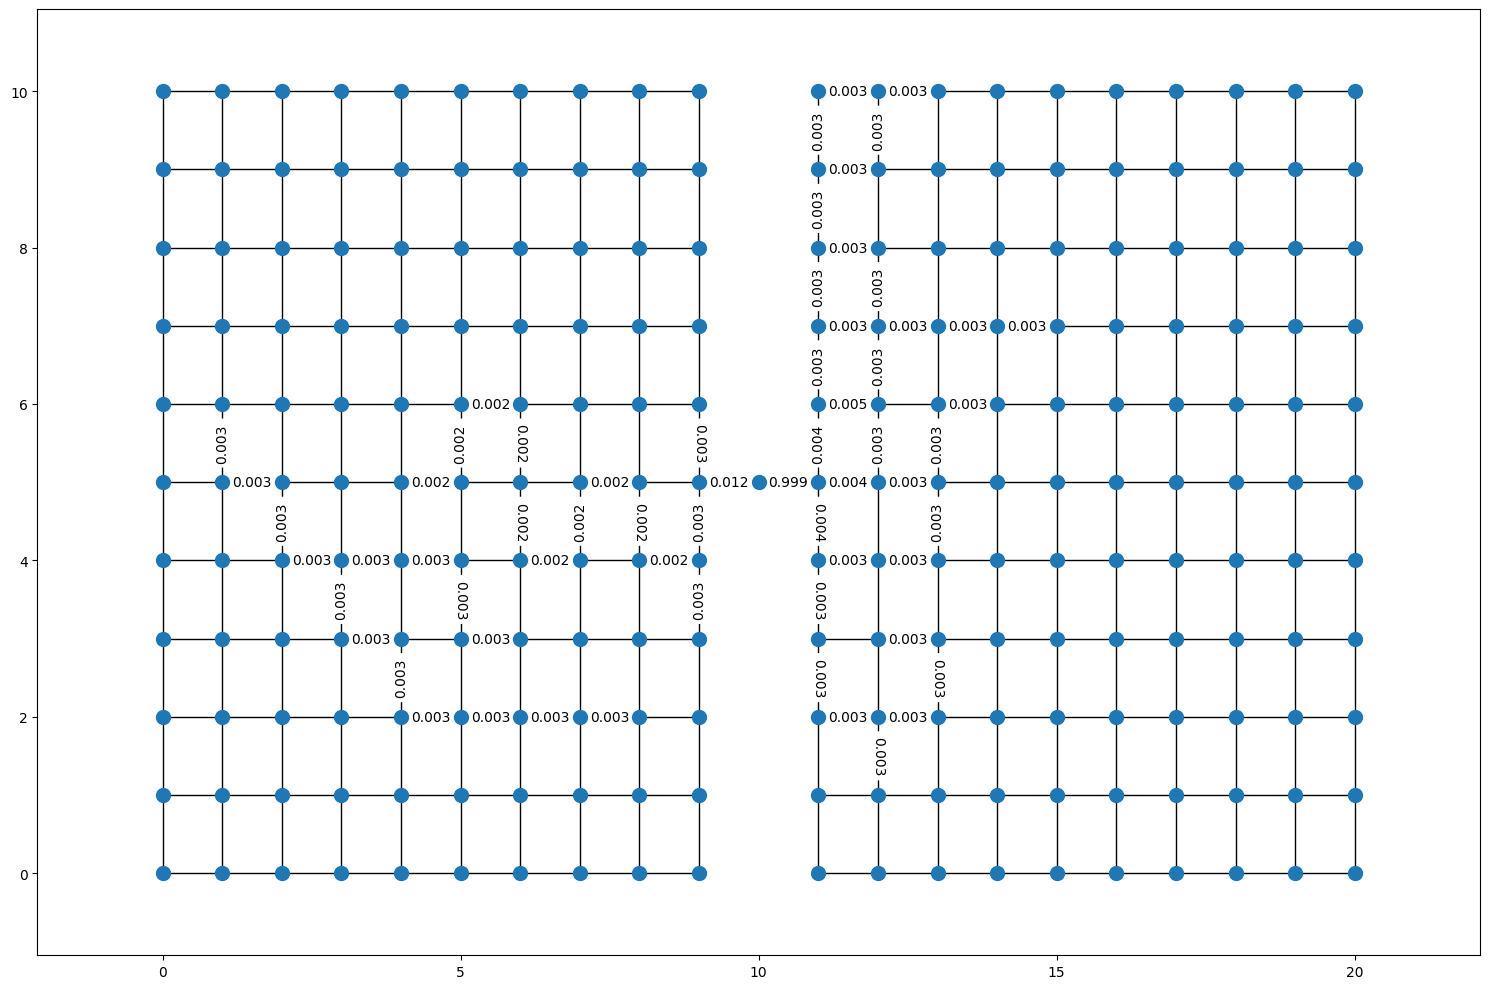

In [ ]:
bottlenecks = dict[tuple, list[float]]()
for seed in range(50):
    finder = LocalGraphBottleneckFinder()
    trainer = LocalGraphTrainer(dqn_trainer, finder)
    exp = marl.Experiment.create("logs/test", trainer=trainer, n_steps=1_000_000, test_interval=0, env=env)
    print(f"Experiment {seed + 1}/50")
    exp.run(seed)
    graph, vertex_positions, bottleneck_probs = get_bottlenecks_stats(finder)
    for edge, prob in bottleneck_probs.items():
        if edge not in bottlenecks:
            bottlenecks[edge] = []
        bottlenecks[edge].append(prob)
    #show_bottlenecks(graph, vertex_positions, bottleneck_probs, hit_count, apparition_counts)

total_bottleneck_probs = dict()
for edge, probs in bottlenecks.items():
    total_bottleneck_probs[edge] = np.mean(probs)
    print(edge, len(probs), np.mean(probs), np.std(probs))

show_bottlenecks(graph, vertex_positions, total_bottleneck_probs)

{((4, 11), (4, 12)): 0.0027548209366391185, ((4, 12), (4, 13)): 0.0027548209366391185, ((4, 13), (5, 13)): 0.0027548209366391185, ((5, 9), (5, 10)): 0.012119921061989126, ((5, 10), (5, 11)): 0.9987895262934071, ((5, 11), (4, 11)): 0.004269870249924209, ((3, 9), (4, 9)): 0.0026954177897574125, ((4, 9), (5, 9)): 0.0025832742813874893, ((6, 11), (7, 11)): 0.002663091129406184, ((7, 11), (7, 12)): 0.0026352702627631796, ((7, 12), (7, 13)): 0.0026595744680851063, ((7, 13), (7, 14)): 0.0026595744680851063, ((7, 14), (7, 15)): 0.0026595744680851063, ((7, 11), (8, 11)): 0.0027031963470319637, ((5, 11), (5, 12)): 0.004382823583236223, ((5, 11), (6, 11)): 0.00438736832554058, ((9, 11), (9, 12)): 0.002617801047120419, ((9, 12), (10, 12)): 0.002617801047120419, ((5, 12), (6, 12)): 0.0025886276464627857, ((7, 12), (8, 12)): 0.0026109660574412533, ((8, 11), (9, 11)): 0.0026109660574412533, ((8, 12), (8, 11)): 0.0026109660574412533, ((9, 11), (10, 11)): 0.0026109660574412533, ((10, 11), (10, 12)): 0.

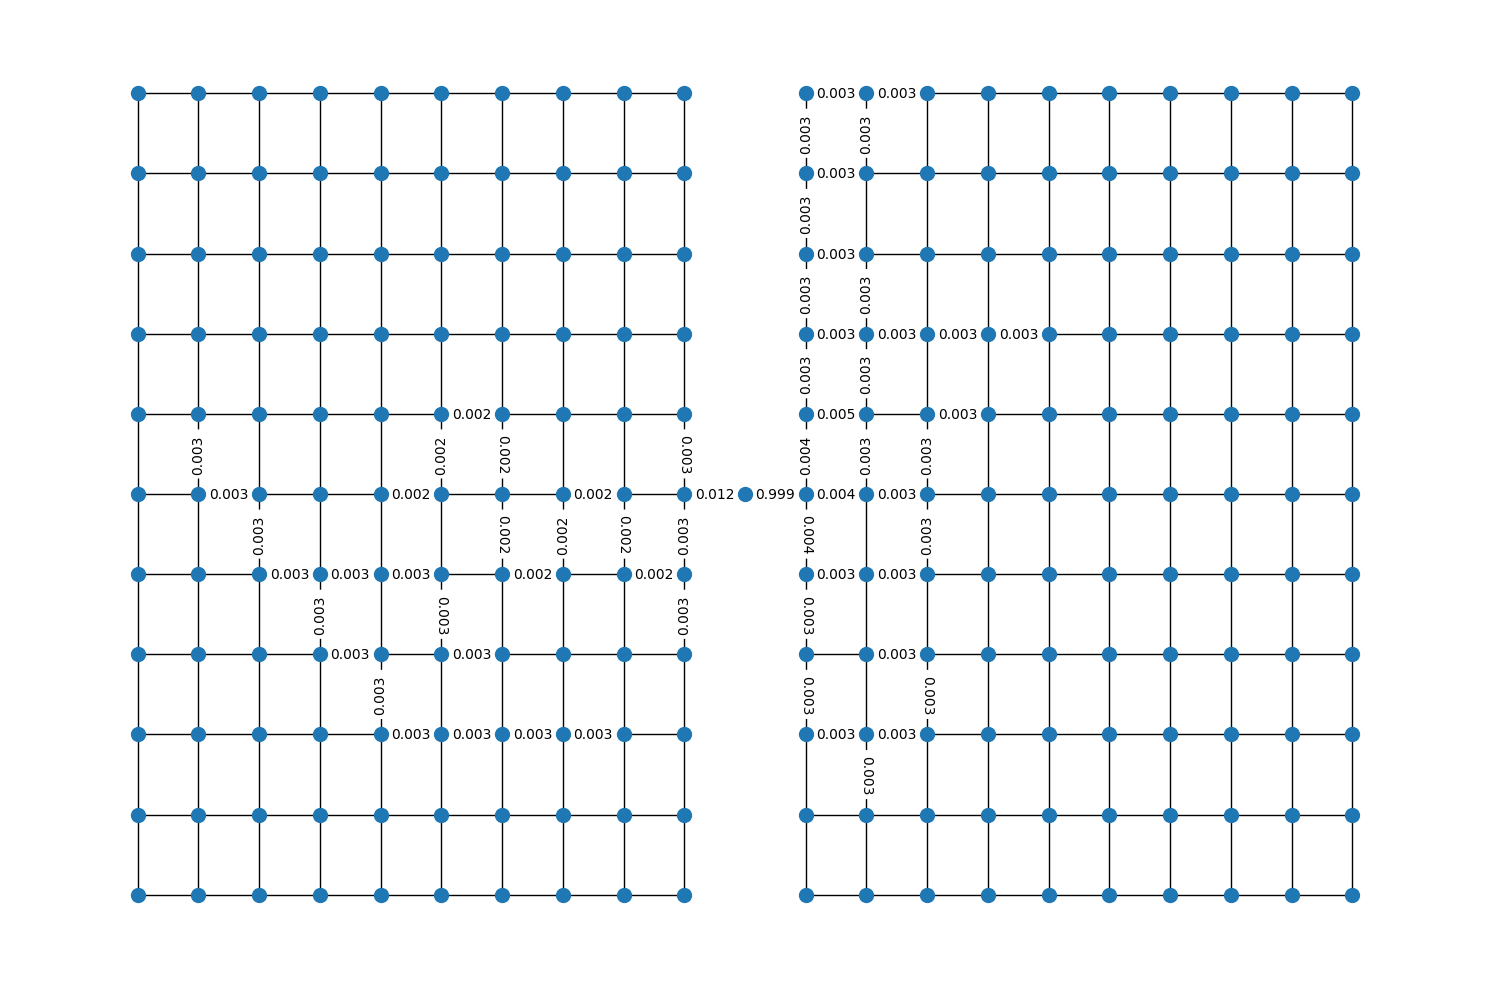

In [28]:
import json
total_bottleneck_probs = dict()
for edge, probs in bottlenecks.items():
    total_bottleneck_probs[edge] = float(np.mean(probs))

print(total_bottleneck_probs)
with open("bottlenecks.json", "w") as f:
    json_data = {str(k): v for k, v in total_bottleneck_probs.items()}
    json.dump(json_data, f)

show_bottlenecks(graph, vertex_positions, total_bottleneck_probs)


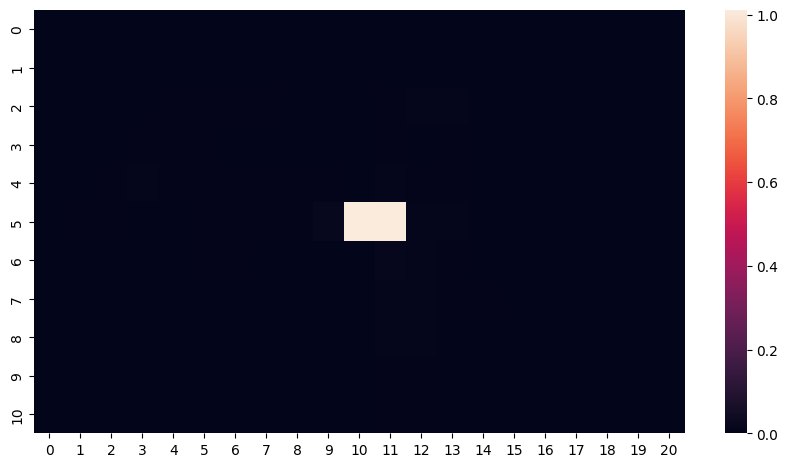

In [35]:
import seaborn as sns
heatmap = np.zeros((world.height, world.width))
for edge, prob in total_bottleneck_probs.items():
    start, end = edge
    heatmap[start] += prob
    heatmap[end] += prob

plt.figure(figsize=(10.5, 5.5))
sns.heatmap(heatmap)
# plt.savefig("heatmap.svg")

plt.show()